# Групповое задание по теме «Классификация текста»
Команда 2

# Описание датасета
### Общая информация

https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews/code

Коллекция рецензий пользователей на фильмы с сайта **kinopoisk.ru**:
- положительных: 87101;
- отрицательных: 19804;
- нейтральных: 24678;
- всего: 131583.

Каждый отзыв хранится в отдельном текстовом файле (.txt). Основное содержимое файла — текст отзыва. Нет явной структуры вроде CSV-файла, просто чистый текст. Папки разделены по тональности отзывов:
neg/ — негативные отзывы (19.8 тыс. файлов);
neu/ — нейтральные отзывы (24.7 тыс. файлов);
pos/ — положительные отзывы (87.1 тыс. файлов).

**Вес файлов**: 539.31 МБ.

**Метод разметки**: пользователи сайта самостоятельно указывают категорию отзыва.


Разметка в целом соответствует содержанию. Пример: «Это похоже на бред сумасшедшего…» отрицательный отзыв, а «В целом идея хорошая, и три сезона по 10 серий не такие уж длинные. Но мне показалось, что сюжет подтянут… 6 из 10.» как нейтральный.


### Гипотеза
Наличие нейтральных отзывов в датасете фильмов снижает точность модели классификации отзывов по тональности (положительные и отрицательные), поскольку нейтральные тексты имею размытые признаки и могут "размывать" границы между положительными и отрицательными классами.

# Загрузка датасета **Kinopoisk's movies reviews**


## Подключение Kaggle и установка файлов датасета

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# create a kaggle folder
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download mikhailklemin/kinopoisks-movies-reviews

Dataset URL: https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews
License(s): unknown
 82% 182M/222M [00:00<00:00, 523MB/s] 
100% 222M/222M [00:00<00:00, 440MB/s]


In [ ]:
!unzip kinopoisks-movies-reviews.zip

## Подготовка датасета

In [ ]:
!pip install spacy
!python -m spacy download ru_core_news_sm

In [ ]:
import os
import re

import numpy as np
import pandas as pd

import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("russian"))

stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

In [ ]:
nlp = spacy.load("ru_core_news_sm")

# Включить если используется GPU
# spacy.require_gpu()
# spacy.prefer_gpu()

### Функции преобразования

Предварительная подготовка данных включает в себя этапы:
- преобразование текста;
- удаление пунктуации;
- удаление пробельных символов;
- удаление стоп-слов;
- лемматизация.

В блоке ниже представлены функции для предобработки текста, операция лемматизации является наиболее ресурсоёмкой.

In [ ]:
def format_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = re.sub(r"[^А-Яа-яA-Za-z0-9(),!?@\'\`\"\_\n]", " ", text)
    text = re.sub(r"[Ёё]", "е", text)
    text = re.sub(r"[\t\n]", "", text)
    text = re.sub(r"[^А-Яа-яa-zA-Z]", " ", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stop_words(text):
  tokens = text.split()
  tokens = [word for word in tokens if word not in stop_words]
  return " ".join(tokens)

def lemmatize(text):
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc])

def preprocess_text(text):
  text = format_text(text)
  #text = remove_stop_words(text)
  #text = lemmatize(text) # Не используем, так как далее применяем FastText
  return text

### Константы проекта

In [ ]:
DATASET_BASE = './dataset'
RANDOM_STATE = 42
N_SAMPLES_PER_CLASS = 20000  # сколько максимально примеров брать из каждого класса

np.random.seed(RANDOM_STATE)

In [ ]:
df = pd.DataFrame(columns=['text', 'label'])
labels = os.listdir(DATASET_BASE)
print("Найдены классы:", labels)

for label in labels:
    folder = os.path.join(DATASET_BASE, label)
    files = os.listdir(folder)

    np.random.shuffle(files)

    n_to_take = min(len(files), N_SAMPLES_PER_CLASS)
    selected_files = np.random.choice(files, n_to_take, replace=False)

    for filename in selected_files:
        file_path = os.path.join(folder, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            raw_text = f.read().strip()
            processed_text = preprocess_text(raw_text)
            df.loc[len(df)] = [processed_text, label]

df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print("Финальный размер датасета:", df.shape)


Найдены классы: ['pos', 'neg', 'neu']
Финальный размер датасета: (59827, 2)


In [ ]:
df.sample(5)

,text,label
54749,увидев первую серию на одном из каналов кабель...,pos
15077,прочитав в аннотации что да будет свет это фил...,neu
42927,экстравагантно армия мира в общем разрезе войн...,neu
12918,необычный очень статичный местами весьма забав...,neu
51270,крис ван олсберг автор не просто книг а живых ...,neu


Количество уникальных классов

In [ ]:
df['label'].value_counts()

,count
label,
pos,20000
neu,20000
neg,19827


Проверка на пропуски

In [ ]:
df.isnull().sum()

,0
text,0
label,0


Проверка на дубликаты

In [ ]:
df['text'].duplicated().sum()

np.int64(48)

In [ ]:
df.drop_duplicates(subset='text', inplace=True)
df['text'].duplicated().sum()

np.int64(0)

Средняя длина текста, распределение длин

In [ ]:
df['text'].str.split().str.len().describe()

,text
count,59779.000000
mean,336.616655
std,200.738874
min,9.000000
25%,192.000000
50%,290.000000
75%,433.000000
max,1790.000000


Большинство текстов относительно короткие (около 200 слов), но есть и как очень длинные (около 1000 слов), так и очень короткие (менее 10).

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

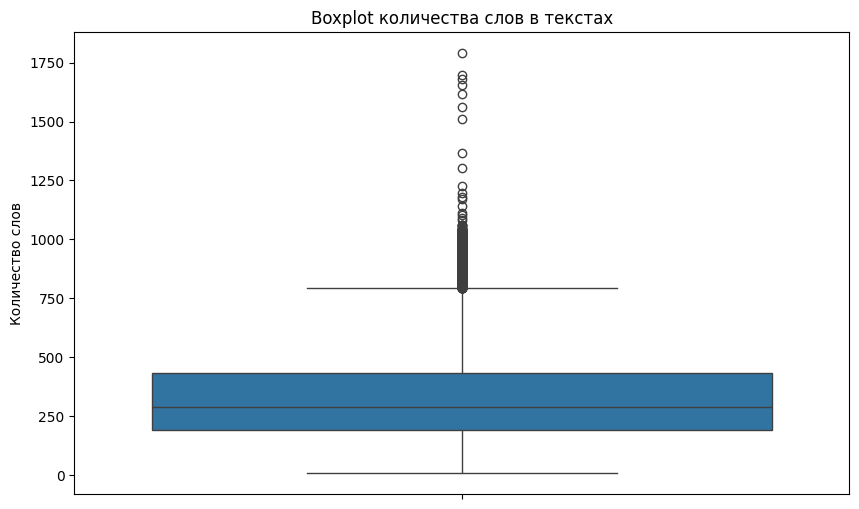

In [ ]:
df['word_count'] = df['text'].str.split().str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='word_count')
plt.title('Boxplot количества слов в текстах')
plt.ylabel('Количество слов')
plt.show()

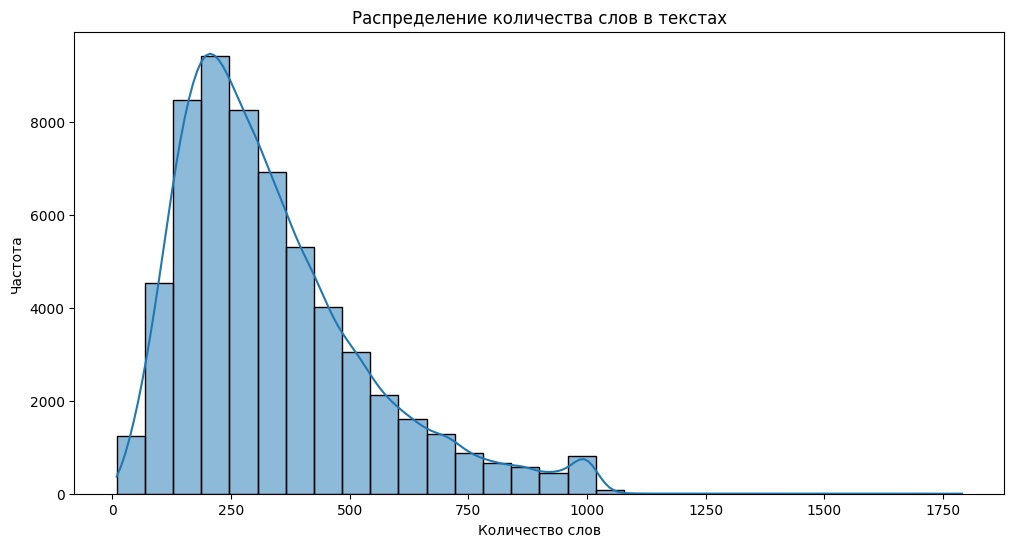

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', bins=30, kde=True)
plt.title('Распределение количества слов в текстах')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.show()

Для большего единообразия обучающей выборки удалим слишком длинные и слишком короткие тексты (более 400 и менее 50 слов)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [ ]:
mask_to_remove = (X_train.str.split().str.len() < 50) | (X_train.str.split().str.len() > 700)

X_train_cleaned = X_train[~mask_to_remove]
y_train_cleaned = y_train[~mask_to_remove]

print(f"Было записей: {len(X_train)}")
print(f"Осталось записей: {len(X_train_cleaned)}")

Было записей: 47823
Осталось записей: 44218


In [ ]:
X_train_cleaned.head()

,text
29199,шон босуэлл настоящий хулиган он не может ужит...
2374,колхозница и москва внезапное единение душ и о...
32849,недостаточно быть сценаристом российских сериа...
34467,страх подхватить какую нибудь инфекцию силен в...
590,сюжет прихода к еврейской бездетной семье подо...


# Классификация по 3 категориям

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 21.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)


Для векторизации используем готовую модель FastText.

In [ ]:
import fasttext
import fasttext.util

fasttext.util.download_model('ru', if_exists='ignore')
ft_model = fasttext.load_model("cc.ru.300.bin")

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, LSTM, Input
from sklearn.preprocessing import LabelEncoder

# ---------------- Кодирование меток ----------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_cleaned)
y_test_enc = le.transform(y_test)

# ---------------- Определяем размер embedding ----------------
embedding_dim = ft_model.get_word_vector("test").shape[0]  # корректная размерность
max_len = 50  # максимальная длина последовательности

# ---------------- Генератор батчей ----------------
def batch_generator(texts, labels, batch_size=32):
    n = len(texts)
    while True:
        for i in range(0, n, batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            X_batch = np.zeros((len(batch_texts), max_len, embedding_dim), dtype=np.float32)
            for j, text in enumerate(batch_texts):
                words = text.split()
                for k, word in enumerate(words):
                    if k >= max_len:
                        break
                    X_batch[j, k, :] = ft_model.get_word_vector(word)

            yield X_batch, np.array(batch_labels)

# ---------------- Простая CNN ----------------
cnn_model = Sequential([
    Input(shape=(max_len, embedding_dim)),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_model.fit(
    batch_generator(X_train_cleaned, y_train_enc),
    steps_per_epoch=len(X_train_cleaned)//32,
    epochs=5,
    validation_data=batch_generator(X_test, y_test_enc),
    validation_steps=len(X_test)//32
)

# ---------------- Простая LSTM ----------------
rnn_model = Sequential([
    Input(shape=(max_len, embedding_dim)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.fit(
    batch_generator(X_train_cleaned, y_train_enc),
    steps_per_epoch=len(X_train_cleaned)//32,
    epochs=5,
    validation_data=batch_generator(X_test, y_test_enc),
    validation_steps=len(X_test)//32
)


Epoch 1/5
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 71s 50ms/step - accuracy: 0.3884 - loss: 1.0840 - val_accuracy: 0.4357 - val_loss: 1.0516
Epoch 2/5
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 67s 49ms/step - accuracy: 0.4671 - loss: 1.0284 - val_accuracy: 0.4649 - val_loss: 1.0296
Epoch 3/5
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.5059 - loss: 0.9798 - val_accuracy: 0.4653 - val_loss: 1.0346
Epoch 4/5
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 67s 49ms/step - accuracy: 0.5408 - loss: 0.9320 - val_accuracy: 0.4658 - val_loss: 1.0632
Epoch 5/5
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 83s 60ms/step - accuracy: 0.5804 - loss: 0.8812 - val_accuracy: 0.4609 - val_loss: 1.1141
Epoch 1/5
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 112s 80ms/step - accuracy: 0.3937 - loss: 1.0755 - val_accuracy: 0.4545 - val_loss: 1.0297
Epoch 2/5
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 141s 102ms/step - accuracy: 0.4713 - loss: 1.0219 - val_accuracy: 0.4693 - val_loss: 1.0159
Epoch 3/5
1381/1381 ━━━━━━━━━━━━━━━━━━━━ 109s 79ms/step - accuracy: 0.4820 - los

Создадим ансамбль из CNN и RNN моделей. Веса подберем при помощи Optuna.

In [ ]:
import optuna
from sklearn.metrics import accuracy_score
import numpy as np

# ---------------- Функция для генерации предсказаний ----------------
def get_preds(model, texts, batch_size=32):
    preds = []
    gen = batch_generator(texts, y_test_enc, batch_size)
    steps = len(texts) // batch_size + 1
    for _ in range(steps):
        X_batch, _ = next(gen)
        preds.append(model.predict(X_batch))
    return np.vstack(preds)[:len(texts)]

# ---------------- Функция для расчета accuracy ансамбля ----------------
def ensemble_accuracy(weights):
    w1, w2 = weights
    cnn_preds = get_preds(cnn_model, X_test)
    rnn_preds = get_preds(rnn_model, X_test)

    # Soft voting с весами
    ensemble_preds = (w1 * cnn_preds + w2 * rnn_preds) / (w1 + w2)
    y_pred = ensemble_preds.argmax(axis=1)

    return accuracy_score(y_test_enc, y_pred)

# ---------------- Оптимизация весов ----------------
def objective(trial):
    w1 = trial.suggest_float("w1", 0.5, 5.0)
    w2 = trial.suggest_float("w2", 0.5, 5.0)
    return ensemble_accuracy([w1, w2])


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

In [ ]:
print("Лучшие веса:", [study.best_params['w1'], study.best_params['w2']])
print("Лучший score:", study.best_value)

Лучшие веса: [1.2122556601559402, 2.1978308684059638]
Лучший score: 0.4882067581130813


Ансамбль не дал существенного прироста метрик по сравнению с отдельными моделями.

# Бинарная классификация

Проверим гипотезу: наличие нейтральных отзывов в датасете фильмов снижает точность моделей.

In [ ]:
labels = ['neg', 'pos']
df = df[df['label'].isin(labels)]

df['label'].value_counts()

,count
label,
pos,19995
neg,19803


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [ ]:
mask_to_remove = (X_train.str.split().str.len() < 50) | (X_train.str.split().str.len() > 700)

X_train_cleaned = X_train[~mask_to_remove]
y_train_cleaned = y_train[~mask_to_remove]

In [ ]:
y_train_enc = le.fit_transform(y_train_cleaned)
y_test_enc = le.transform(y_test)


cnn_model.fit(
    batch_generator(X_train_cleaned, y_train_enc),
    steps_per_epoch=len(X_train_cleaned)//32,
    epochs=5,
    validation_data=batch_generator(X_test, y_test_enc),
    validation_steps=len(X_test)//32
)


rnn_model.fit(
    batch_generator(X_train_cleaned, y_train_enc),
    steps_per_epoch=len(X_train_cleaned)//32,
    epochs=5,
    validation_data=batch_generator(X_test, y_test_enc),
    validation_steps=len(X_test)//32
)


Epoch 1/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.6197 - loss: 0.7095 - val_accuracy: 0.7172 - val_loss: 0.5836
Epoch 2/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.8214 - loss: 0.4030 - val_accuracy: 0.7138 - val_loss: 0.6532
Epoch 3/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.8704 - loss: 0.3178 - val_accuracy: 0.7067 - val_loss: 0.7543
Epoch 4/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 48s 52ms/step - accuracy: 0.9069 - loss: 0.2475 - val_accuracy: 0.6982 - val_loss: 0.8783
Epoch 5/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 83s 91ms/step - accuracy: 0.9272 - loss: 0.2005 - val_accuracy: 0.6860 - val_loss: 1.0541
Epoch 1/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - accuracy: 0.6936 - loss: 0.5857 - val_accuracy: 0.7224 - val_loss: 0.5366
Epoch 2/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.7413 - loss: 0.5133 - val_accuracy: 0.7216 - val_loss: 0.5413
Epoch 3/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 75s 81ms/step - accuracy: 0.7511 - loss: 0.4973 - val_accu

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Лучшие веса:", [study.best_params['w1'], study.best_params['w2']])
print("Лучший score:", study.best_value)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━